# H2 - srovnání mapování a optimalizačních technik v rámci VQE pro STO-3G
V tomto notebooku provedeme srovnání simulace molekulárního vodíku pomocí VQE při různých volbách mapování, ansatzu a optimalizátorů. Fixní zde přitom bude volba bazického souboru STO-3G. Výsledky budou posuzovány z hlediska výsledné chyby, užitého počtu CNOT bran, počtu parametrů a dalších hledisek.

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.0', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.5.2', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.0', 'qiskit-nature': '0.4.3', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

Molekulu nyní již inicializujeme v optimální vzdálenosti jader. Jako driver používáme Psi4.

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["H", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, 0.735]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PSI4,
)

properties = driver.run()

Můžeme si zobrazit některé vlastnosti molekuly:

In [3]:
#print(properties)

# print number of electrons
num_alpha_electrons = properties.get_property("ParticleNumber").num_alpha
num_beta_electrons = properties.get_property("ParticleNumber").num_beta
num_electrons = num_alpha_electrons + num_beta_electrons
print("Number of electrons: " + str(num_electrons))

#print number of spin-orbitals
num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
print("Number of spin orbitals: " + str(num_spin_orbitals))

# print nuclear repulsion energy
nuclear_rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
print("Nuclea repulsion energy: " + str(nuclear_rep_energy))

Number of electrons: 2
Number of spin orbitals: 4
Nuclea repulsion energy: 0.7199689941088435


Fermionový Hamiltonián zde bude:

In [4]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver)

second_q_ops = problem.second_q_ops()

hamiltonian = second_q_ops[0]

print(hamiltonian)

Fermionic Operator
register length=4, number terms=36
  -1.2563390727924975 * ( +_0 -_0 )
+ -0.4718960075031837 * ( +_1 -_1 )
+ -1.2563390727924975 * ( +_2 -_2 )
+ -0.4718960075031837 * ( +_3 -_3 )
+ -0.3378550773686211 * ( +_0 +_0 -_0 -_0 )
+ -0.090 ...


Zde si připravíme jednotlivé typy mapování, které následně můžeme měnit.

In [5]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'BravyiKitaevMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(hamiltonian)
print(qubit_op)

-0.8105479806514229 * IIII
+ 0.17218393256544937 * IIIZ
- 0.22575349206186732 * IIZZ
+ 0.17218393256544937 * IZII
- 0.22575349206186734 * ZZZI
+ 0.12091263259779463 * IIZI
+ 0.16892753868431054 * IZIZ
+ 0.04523279995089952 * ZXIX
- 0.04523279995089952 * IXZX
- 0.04523279995089952 * ZXZX
+ 0.04523279995089952 * IXIX
+ 0.16614543254869418 * ZZZZ
+ 0.16614543254869418 * IZZZ
+ 0.17464343066697036 * ZZIZ
+ 0.12091263259779463 * ZIZI


Zde si připravíme počáteční stav jako Hartree-Fockův. Upozorněme, že zatímco podle teorie by H-F stav měl být |0011>, tak zde se bude lišit díky rozdílnému řezení qubitů v Qiskitu střídavě spin-up spin-down.

In [6]:
from qiskit_nature.circuit.library import HartreeFock

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles


init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     └───┘
q_3: ─────
          


Zde si připravíme atributy pro používání jednotlivých ansatzů. Z heustických volíme možnost TwoLocal, z fyzikálně motivovaných volíme UCCSD (Unitary Coupled Cluster Single and Double), PUCCD (paired-electrons UCCD) a SUCCD.

In [7]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "TwoLocal"


# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cz'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)

print(ansatz.decompose())

     ┌───────────┐┌──────────┐┌──────────┐                  
q_0: ┤ U3(π,0,π) ├┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─■──■─────■───────
     ├───────────┤├──────────┤├──────────┤ │  │     │       
q_1: ┤ U3(π,0,π) ├┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─■──┼──■──┼──■────
     ├───────────┤├──────────┤├──────────┤    │  │  │  │    
q_2: ┤ U3(π,0,π) ├┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├────■──■──┼──┼──■─
     └┬──────────┤├──────────┤└──────────┘          │  │  │ 
q_3: ─┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├──────────────────────■──■──■─
      └──────────┘└──────────┘                              


Jako backend bude opět používat Statevector Simulator.

In [8]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

Z klasických optimalzačních technik volíme tři uvedené v práci (NELDER_MEAD, SPSA, L_BFGS_B) a jednu častou užívanou navíc - COBYLA.

In [9]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, NELDER_MEAD

optimizer_type = 'COBYLA'

# we set some default parameters for the optimizers
if optimizer_type == 'NELDER_MEAD':
    optimizer = NELDER_MEAD(maxiter=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)

Pro porovnání a spočítání chyby opět úlohu spočítáme též klasicky. Připomeňme, že při dřívějších výpočtech byla do celkové energie základního stavu zahrnuta i energie odpuzování jader (Total ground state energy), zatímco teď se zajímáme skutečně jen o elektronovou energii posunutou o konstantu. 

In [10]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.8572750298621858
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275029862
  - computed part:      -1.857275029862
~ Nuclear repulsion energy (Hartree): 0.719968994109
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  -1.3889487]
    - computed part:      [0.0  0.0  -1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


Nyní již spustíme úlohu pro zvolené mapování a ansatz. Jako volbu počátečních parametrů přitom uvažujeme 

In [11]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 110,
    'eigenstate': array([-7.86901885e-16+9.45576511e-16j, -2.11677036e-11+4.72538204e-11j,
        4.01604169e-10+3.21035551e-11j, -1.66422244e-05+3.25488637e-06j,
       -4.91840959e-11+5.33255975e-11j,  1.38858490e-06-2.71940333e-06j,
       -2.35557748e-05-3.09694195e-06j, -9.89908352e-01+1.41709049e-01j,
        6.20780967e-21+8.88670960e-22j, -2.61699767e-16+3.44063820e-17j,
        9.33996256e-16+1.82913737e-15j,  5.86084081e-11+6.35434753e-11j,
       -3.62935498e-16-7.09829273e-17j, -1.55159661e-11+1.24031998e-12j,
        4.95132133e-11+1.10531049e-10j, -3.26084749e-06-3.91838024e-06j]),
    'eigenvalue': (-1.8369679901561728+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -4.751696868623025e-05,
                              ParameterVectorElement(θ[7]): 1.0189192538929306,
                              ParameterVectorElement(θ[6]): 0.05095430262955199,
                              Paramet

Výsledky budeme ukládat do csv tabulky. Pro přehlednost budeme mít pro každé mapování vlastní tabulku.

,optimizer,ansatz,rotation blocks,entanglement_blocks,entanglement,repetitions,# of qubits,# of parameters,# of CNOTs,# of evaluations,error (mHa)
0,NELDER_MEAD,UCCSD,NaN,NaN,NaN,NaN,4,3,38,142,1.711393e-06
1,NELDER_MEAD,PUCCD,NaN,NaN,NaN,NaN,4,1,32,34,5.586276e-07
2,NELDER_MEAD,SUCCD,NaN,NaN,NaN,NaN,4,1,32,34,5.586276e-07
3,NELDER_MEAD,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,242,2.030704e+01
4,SPSA,UCCSD,NaN,NaN,NaN,NaN,4,3,38,1000,1.962271e-02
5,SPSA,PUCCD,NaN,NaN,NaN,NaN,4,1,32,1000,-4.440892e-13
6,SPSA,SUCCD,NaN,NaN,NaN,NaN,4,1,32,1000,-4.440892e-13
7,SPSA,TwoLocal,"['ry', 'rz']",cz,full,1.0,4,8,6,1000,6.009360e+02
8,L_BFGS_B,UCCSD,NaN,NaN,NaN,NaN,4,3,38,24,6.450396e-10
9,L_BFGS_B,PUCCD,NaN,NaN,NaN,NaN,4,1,32,10,2.220446e-12


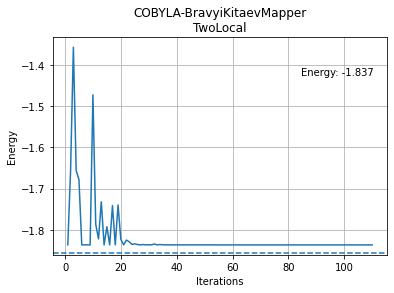

In [12]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']

energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.cost_function_evals,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f}).png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2_sto3g_BK.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', 'rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', '# of qubits', '# of parameters', '# of CNOTs', '# of evaluations', 'error (mHa)']]

In [13]:
#This code is a modification of IBM Quantum Spring Challenge 2022 